In [1]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-06-10 15:22:17--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-10 15:22:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-06-10 15:24:57 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [2]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df = pd.read_csv('/content/spam.csv')
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sentences = df['Message'].tolist()
labels = df['Category'].tolist()

In [6]:
train_size = int(len(sentences) * 0.9)

In [7]:
training_sentences = sentences[0:train_size]
testing_sentences = sentences[train_size:]
training_labels = labels[0:train_size]
testing_labels = labels[train_size:]

In [8]:
import numpy as np
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [9]:
vocab_size = 500
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [13]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

ok lar <OOV> wif u <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Ok lar... Joking wif u oni...


In [14]:
import os
embedding_index = {}
embedding_dim = 100
f = open(os.path.join('/content/glove.6B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=20,  dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           855200    
                                                                 
 lstm (LSTM)                 (None, 20)                9680      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 864901 (3.30 MB)
Trainable params: 9701 (37.89 KB)
Non-trainable params: 855200 (3.26 MB)
_________________________________________________________________


In [20]:
num_epochs = 30
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
157/157 [==============================] - 41s 200ms/step - loss: 0.4217 - accuracy: 0.8706 - val_loss: 0.1894 - val_accuracy: 0.9606
Epoch 2/30
157/157 [==============================] - 54s 343ms/step - loss: 0.1670 - accuracy: 0.9505 - val_loss: 0.1151 - val_accuracy: 0.9552
Epoch 3/30
157/157 [==============================] - 30s 193ms/step - loss: 0.1268 - accuracy: 0.9619 - val_loss: 0.0821 - val_accuracy: 0.9731
Epoch 4/30
157/157 [==============================] - 35s 224ms/step - loss: 0.1047 - accuracy: 0.9703 - val_loss: 0.0886 - val_accuracy: 0.9767
Epoch 5/30
157/157 [==============================] - 36s 225ms/step - loss: 0.0800 - accuracy: 0.9773 - val_loss: 0.0678 - val_accuracy: 0.9821
Epoch 6/30
157/157 [==============================] - 30s 194ms/step - loss: 0.0818 - accuracy: 0.9753 - val_loss: 0.0652 - val_accuracy: 0.9821
Epoch 7/30
157/157 [==============================] - 31s 198ms/step - loss: 0.0717 - accuracy: 0.9805 - val_loss: 0.0589 - val_ac

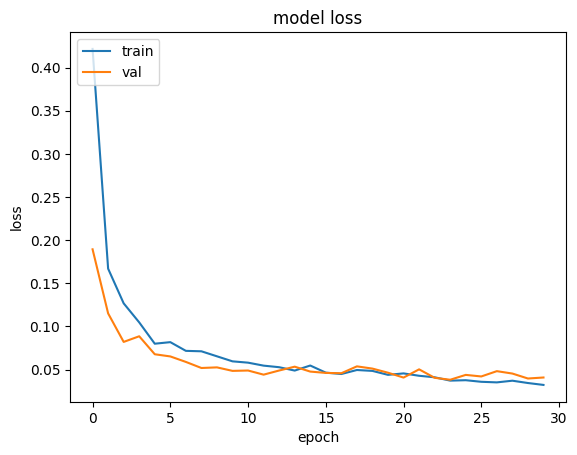

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8552, 100)


In [23]:
text_messages = ['Call me back once you get this?',
                'Congrats on your new offers! Click here to claim your prize...',
                'Really like that new photo of you',
                'Did you hear the news today? Total fiasco',
                'Attend this data science meet...',
                'Are you coming to the party tonight?',
                'Your items have gone missing, let me know if you find them',
                'Do not forget to bring your friends!',
                'You have won a million dollars! Fill out your bank details here...',
                'Looking forward to seeing you again']

In [24]:
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)
classes = model.predict(fakes_padded)

1/1 [==============================] - 0s 419ms/step


In [25]:
for x in range(len(text_messages)):
    print(text_messages[x])
    print(classes[x])
    print('\n')

Call me back once you get this?
[0.00117425]


Congrats on your new offers! Click here to claim your prize...
[0.9972269]


Really like that new photo of you
[0.00096208]


Did you hear the news today? Total fiasco
[0.00081231]


Attend this data science meet...
[0.00288106]


Are you coming to the party tonight?
[0.0012694]


Your items have gone missing, let me know if you find them
[0.00095673]


Do not forget to bring your friends!
[0.00089545]


You have won a million dollars! Fill out your bank details here...
[0.14368522]


Looking forward to seeing you again
[0.00147556]


